## Stochastic-Benchmark on Simulated Annealing

We deploy stochastic benchmark on 20 instances solved using Simulated Annealing with sweeps = 1000, schedule = geometric, and num_read = 1000

In [1]:

import sys

sys.path.append("../../src")
import stochastic_benchmark as SB
import numpy as np
import os
import bootstrap
import interpolate
import stats
from utils_ws import *
import pickle
import pandas as pd
import dimod
import success_metrics

In [2]:
here = os.getcwd()
parameter_names = ["num_sweeps"]            # add "schedule" if you want separate curves // why would I want num_reads?
instance_cols = ["instance"]

# We precomputed per-read 'perf_ratio' in raw_df and will use Response metric to maximize it
response_key = "Response"                   # aligns with bootstrap's output column name
response_dir = 1
recover = True
reduce_mem = True
smooth = True

sb = SB.stochastic_benchmark(
    parameter_names=parameter_names,
    here=here,
    instance_cols=instance_cols,
    response_key=response_key,
    reduce_mem=reduce_mem,
    smooth=smooth,
)

In [3]:
""" file_path = "raw_run_pkl/instance_0.pkl"

# Load the pickle file
with open(file_path, "rb") as f:
    data = pickle.load(f)

# Check if it's a DataFrame and print columns
if isinstance(data, pd.DataFrame):
    print("Column names:")
    print(data.columns.tolist())
    print(data.head())
else:
    print("The pickle file does not contain a pandas DataFrame.")
    print("Type of object:", type(data))
    """

' file_path = "raw_run_pkl/instance_0.pkl"\n\n# Load the pickle file\nwith open(file_path, "rb") as f:\n    data = pickle.load(f)\n\n# Check if it\'s a DataFrame and print columns\nif isinstance(data, pd.DataFrame):\n    print("Column names:")\n    print(data.columns.tolist())\n    print(data.head())\nelse:\n    print("The pickle file does not contain a pandas DataFrame.")\n    print("Type of object:", type(data))\n    '

### sampleset-per-sweep data to instance-wise data conversion
.p data conversion to .pkl 20 files 
each containing many rows for runs on varying params on same instance

**Performance Ratio as our success metric**  

$$
\text{Performance Ratio} =\frac{found - random}{minimum - random}
$$
Where $found$ corresponds to the best found solution within our sampling, $random$ is the mean of the random sampling shown above, and $minimum$ corresponds to the best found solution to our problem during the exploration. Consider that this minimum might not be the global minimum.
This metric is very informative given that the best performance you can have is 1, being at the minimum, and negative values would correspond to a method that at best behaves worse that the random sampling.
Success now is counted as being within certain treshold of this value of 1.
This new way of measuring each method is very similar to the approximation ratio of approximation algorithms, therefore we will use that terminology from now on.

In [4]:
# dictionary for storing min energy and random energy for each instance

# first pass: compute min_energy and random_energy for each instance from raw data

# min_energy : minimum energy across all parameter settings and all runs you consider for that instance
# random_energy : run RandomSampler once for that instance with num_reads = 1000 and take the mean of the energies

# these values are used to calculate performance ratio accross sweeps (and num_reads) for each instance so comparable

def min_energy_from_sampleset(ss):
   return float(np.min(ss.data_vectors['energy']))

def min_energy_from_instance(instance_files):
    # best_value across all files for that instance
    best = float('inf')
    for path in instance_files:
        with open(path,'rb') as f:
            obj = pickle.load(f)
        sets = obj if isinstance(obj, (list,tuple)) else [obj]
        for ss in sets:
            best = min(best, min_energy_from_sampleset(ss))
    return best

def random_energy_for_instance():
    # run RandomSampler once for that instance with num_reads = 1000 and take the mean of the energies
    N = 100 # Number of variables
    np.random.seed(42) # Fixing the random seed to get the same result
    J = np.random.rand(N,N)
    J = np.triu(J, 1) # We only consider upper triangular matrix ignoring the diagonal
    h = np.random.rand(N)
    model_random = dimod.BinaryQuadraticModel.from_ising(h, J, offset=0.0)
    randomSampler = dimod.RandomSampler()
    randomSample = randomSampler.sample(model_random, num_reads=1000)
    energies = [datum.energy for datum in randomSample.data(
            ['energy'], sorted_by='energy')]
    random_energy = np.mean(energies)
    return random_energy

# parsing the file to get the instance id, schedule (not used currently), num_sweeps
rows = []
root = "raw_runs"
by_instance = {}
for fname in os.listdir(root):
    inst, schedule, sweeps = os.path.splitext(fname)[0].split('_')
    by_instance.setdefault(int(inst), []).append(os.path.join(root,fname))
    

# Computing min_energy and random_energy for each instance
instance_min = {}
instance_random = {}

for inst, files in by_instance.items():
    instance_min[inst] = min_energy_from_instance(files)
    instance_random[inst] = random_energy_for_instance()


In [5]:
# computing performance ratio for each instance at each sweep for fixed num_reads 
# instance, num_sweeps, num_reads(=len(sample_set)), performance_ratio
# num reads will remain the same for all sweeps for the given instance

# "reads” is emulated in bootstrap via the boots loop and used only for plotting (sweeps × boot).

rows = []
for fname in os.listdir(root):
    if not fname.endswith('.p'):
        continue
    inst_str, schedule, sweeps_str = os.path.splitext(fname)[0].split('_')
    inst = int(inst_str)
    num_sweeps = int(sweeps_str)

    with open(os.path.join(root, fname), 'rb') as f:
        samples = pickle.load(f)

    # Per-instance baselines
    min_energy = instance_min[inst]
    random_energy = instance_random[inst]

    # 2) One row per read with per-read perf_ratio (so resampling is useful)
    energies = np.asarray(samples.data_vectors['energy'])
    #best_energy_sweep = min_energy_from_sampleset(samples)
    perf_ratio_reads = (random_energy - energies) / (random_energy - min_energy)
    #perf_ratio  =  (random_energy - best_energy_sweep) / (random_energy - min_energy)
    perf_ratio_reads = np.clip(perf_ratio_reads, 0.0, 1.0)
    #perf_ratio =  np.clip(perf_ratio, 0.0, 1.0)
    """
    currently I am deviating away from the definition required the minimum energy per sampe set because I think if we dont
    give the benchmark varying performance ratio with num_reads and only give the minimum per sweep for 1000 reads it won't be able to
    resample and accurately predict the nature at 10th, 100th, 1000th sweep right?
    """

    for pr in perf_ratio_reads:
        rows.append({
                'instance': inst,
                #'schedule': schedule,   # optional
                'num_sweeps': num_sweeps,
                'acc_num_reads': len(samples), # is constant for all sweeps (acquisition reads) (according to the data)
                'perf_ratio': float(pr),    # calculated per read           
                #'perf_ratio' : perf_ratio ,          
                'resource': num_sweeps # base resource is just sweeps; boots will scale it during bootstrap
        })

raw_df = pd.DataFrame(rows)
raw_df.to_pickle('checkpoints/raw_runs_perf_ratio_per_read.pkl')
print(f'Wrote {len(raw_df)} rows to checkpoints/raw_runs_perf_ratio_per_read.pkl')




Wrote 6500000 rows to checkpoints/raw_runs_perf_ratio_per_read.pkl


In [6]:
# bootstrap emulates b effective reads

# load the instances
raw_path = os.path.join(here, "checkpoints", "raw_runs_perf_ratio_per_read.pkl")
raw_df = pd.read_pickle(raw_path)
print(f"Loaded {len(raw_df)} rows from checkpoints")
print(f"Columns: {raw_df.columns.tolist()}")
print(f"Sample:\n{raw_df.head()}")

sb.reduce_mem = False
sb.raw_data = raw_path

shared_args = {
    "response_col": "perf_ratio",
    "resource_col": "resource",
    "response_dir": 1,
    "confidence_level": 68,
}
bsParams = bootstrap.BootstrapParameters(
    shared_args=shared_args,
    update_rule=lambda bs_params, df_group: None,
    success_metrics=[success_metrics.Response],
    metric_args={"Response": {"opt_sense": 1}},
)
boots = [1, 10, 100, 1000]
bs_iter = bootstrap.BSParams_range_iter()(bsParams, boots)



sb.run_Bootstrap(bs_iter)


Loaded 6500000 rows from checkpoints
Columns: ['instance', 'num_sweeps', 'acc_num_reads', 'perf_ratio', 'resource']
Sample:
   instance  num_sweeps  acc_num_reads  perf_ratio  resource
0         0           1           1000    0.670767         1
1         0           1           1000    0.711256         1
2         0           1           1000    0.656363         1
3         0           1           1000    0.664075         1
4         0           1           1000    0.715312         1


In [7]:
# comparing the bootstrapped pkl files

In [8]:
# Interpolation

if os.path.exists('checkpoints/interpolated_results.pkl'):
    os.remove('checkpoints/interpolated_results.pkl') # remove existing file for fresh interpolation

def resource_fcn(df):
    return df["num_sweeps"] * df["boots"] 

iParams = interpolate.InterpolationParameters(resource_fcn, parameters=parameter_names)
sb.run_Interpolate(iParams)

# Verify required columns before Stats
#print([c for c in ['num_sweeps','num_reads','num_shots',"resource"] if c in sb.interp_results.columns])

100%|██████████| 6500/6500 [00:09<00:00, 672.50it/s]


In [10]:

# training.check_split_validity = False
# stats groupby Stats groups by ['num_sweeps','num_reads','num_shots','boots','resource']. 
# Without reset_index(), those parameters remained in the MultiIndex, not in df.columns
#train_test_split = 0.8
#metrics = ["perf_ratio"]
stParams = stats.StatsParameters(metrics=["Response"], stats_measures=[stats.Median()])
# recomputing training stats with
#stParams = stats.StatsParameters(metrics=["PerfRatio"], stats_measures=[stats.Median()])
sb.run_Stats(stParams, train_test_split=0.8)




100%|██████████| 17757/17757 [00:10<00:00, 1626.12it/s]


In [11]:
#the virtual best baseline
sb.run_baseline()


In [12]:
# Projection Experiments
sb.run_ProjectionExperiment("TrainingStats", None, None)
sb.run_ProjectionExperiment("TrainingResults", None, None)
#parameters -> "project from", "post-processes <function to post process the results>", "name of post processor"
# why would I need to post process the ProjectionExperiments?

In [13]:
# Plot the performance and parameters
import plotting

plotting.monotone = True
sb.initPlotting()


100%|██████████| 100/100 [00:00<00:00, 2214.14it/s]


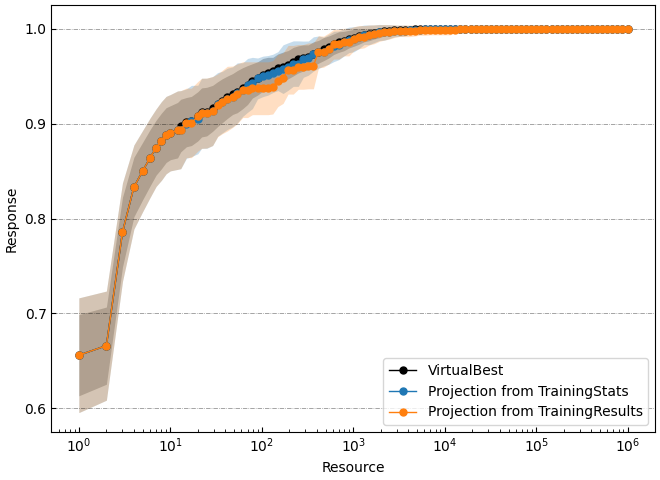

In [14]:
fig, axs = sb.plots.plot_performance()
fig.savefig("performance.png")


100%|██████████| 100/100 [00:00<00:00, 2077.41it/s]


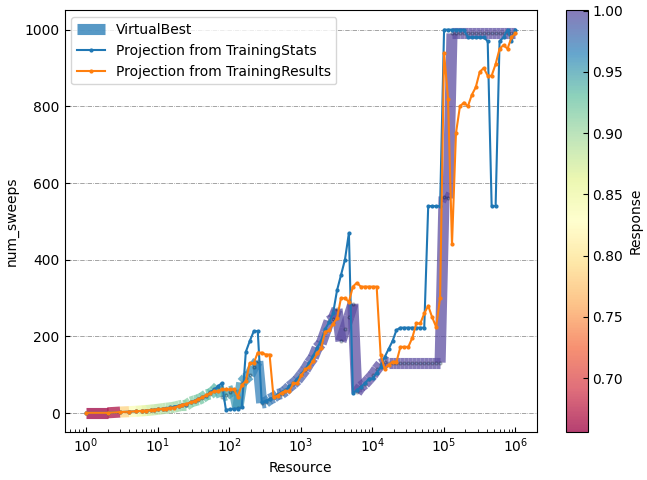

In [15]:
figs, axes = sb.plots.plot_parameters_separate()
for param, fig in figs.items():
    fig.savefig(param + ".png")


In [ ]:

fig, axes = sb.plots.plot_parameters_together()
fig.savefig("all_params.png")


# it is only going to return one graph which is not indexable but what if I want

The implementation below is providing the energies as a parameter column which run_bootstrap can then resample from instead of calculating perRatio at each read for given sweep

In [ ]:
import bootstrap, success_metrics

# response_col is energy; minimize it
shared_args = {
    "response_col": "energy",  # changing from energies to perf_ratio
    "resource_col": "resource",
    "response_dir": -1,
    "confidence_level": 68,
    "random_value": None,  # set in update_rule per instance
}

raw_df["random_value"] = raw_df["instance"].map(instance_random)

def update_rule(bs_params, df_group):
    if bs_params.shared_args["response_dir"] == -1:
        best = df_group[bs_params.shared_args["response_col"]].min()
    else:
        best = df_group[bs_params.shared_args["response_col"]].max()
    bs_params.shared_args["best_value"] = float(best)
    bs_params.shared_args["random_value"] = float(df_group["random_value"].iloc[0])

bsParams = bootstrap.BootstrapParameters(
    shared_args=shared_args,
    update_rule=update_rule,
    success_metrics=[success_metrics.Response, success_metrics.PerfRatio],
    metric_args={"Response": {"opt_sense": -1}},  # minimize energy
) # currently I dont want to try to implement the update rule

boots = [1, 10, 100, 1000]  # effective reads to emulate
bs_iter = bootstrap.BSParams_range_iter()(bsParams, boots)

sb.run_Bootstrap(bs_iter) 

In [ ]:
# Build or load a per-read energy table
# Required columns: ['instance','num_sweeps','energy','resource']

import os, pickle, numpy as np, pandas as pd

root = "raw_runs"  # adjust if needed
rows = []
for fname in os.listdir(root):
    if not fname.endswith(".p"):
        continue
    inst_str, schedule, sweeps_str = os.path.splitext(fname)[0].split("_")
    inst, num_sweeps = int(inst_str), int(sweeps_str)

    with open(os.path.join(root, fname), "rb") as f:
        ss = pickle.load(f)

    energies = np.asarray(ss.data_vectors["energy"])  # per-read energies
    for e in energies:
        rows.append({
            "instance": inst,
            "num_sweeps": num_sweeps,
            "energy": float(e),
            "resource": num_sweeps,   # base; boots will scale it later
        }) # this code mightve been changing the instances

raw_df = pd.DataFrame(rows)
raw_df_path = os.path.join(here, "checkpoints", "raw_runs_energy_per_read.pkl")
os.makedirs(os.path.dirname(raw_df_path), exist_ok=True)
raw_df.to_pickle(raw_df_path)
print(f"Saved {len(raw_df)} rows -> {raw_df_path}")



def random_energy_for_instance(inst, num_reads=1000, N=100, seed=42):
    rng = np.random.default_rng(seed + inst)
    J = rng.random((N, N)); J = np.triu(J, 1)
    h = rng.random(N)
    model = dimod.BinaryQuadraticModel.from_ising(h, J, offset=0.0)
    rs = dimod.RandomSampler().sample(model, num_reads=num_reads)
    return float(np.mean([d.energy for d in rs.data(['energy'])]))

instance_random = {}
for inst in raw_df['instance'].unique():
    instance_random[inst] = random_energy_for_instance(inst)
print("computed random baselines for", len(instance_random), "instances")


import sys, os
sys.path.append(os.path.join(os.getcwd(), "src"))
import stochastic_benchmark as SB
import bootstrap, success_metrics

sb = SB.stochastic_benchmark(
    parameter_names=["num_sweeps"],   # only sweeps is varying
    here=here,
    instance_cols=["instance"],
    response_key="PerfRatio",         # we will optimize PerfRatio downstream
    reduce_mem=False,
    smooth=True,
)

# Attach raw data to the object
sb.recover = False
sb.raw_data = raw_df_path